# Galaxy data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

gal_small_fiducial_df = pd.read_parquet("../data/small_fiducial.parquet")
print('-------columns--------')
print(gal_small_fiducial_df.columns)
print('catalog num: ' + str(len(gal_small_fiducial_df)))

-------columns--------
Index(['mag_true_g_lsst_no_host_extinction', 'dec_true',
       'mag_true_i_lsst_no_host_extinction',
       'Mag_true_g_lsst_z0_no_host_extinction',
       'Mag_true_r_lsst_z0_no_host_extinction',
       'Mag_true_i_lsst_z0_no_host_extinction',
       'mag_true_r_lsst_no_host_extinction', 'galaxyID',
       'mag_true_z_lsst_no_host_extinction',
       'Mag_true_z_lsst_z0_no_host_extinction',
       'Mag_true_u_lsst_z0_no_host_extinction',
       'mag_true_Y_lsst_no_host_extinction',
       'mag_true_u_lsst_no_host_extinction', 'is_central', 'redshift_true',
       'Mag_true_Y_lsst_z0_no_host_extinction', 'ra_true', 'hp_ind_nside128',
       'redshift_measured'],
      dtype='object')
catalog num: 2407311


# Generate GW data

Cosmological parameters used in the simulation:
H0: 71.0 km/s/Mpc
Omega_m: 0.2647887323943662
Omega_lambda: 0.7352112676056338
random seed for galaxy sampling: 41


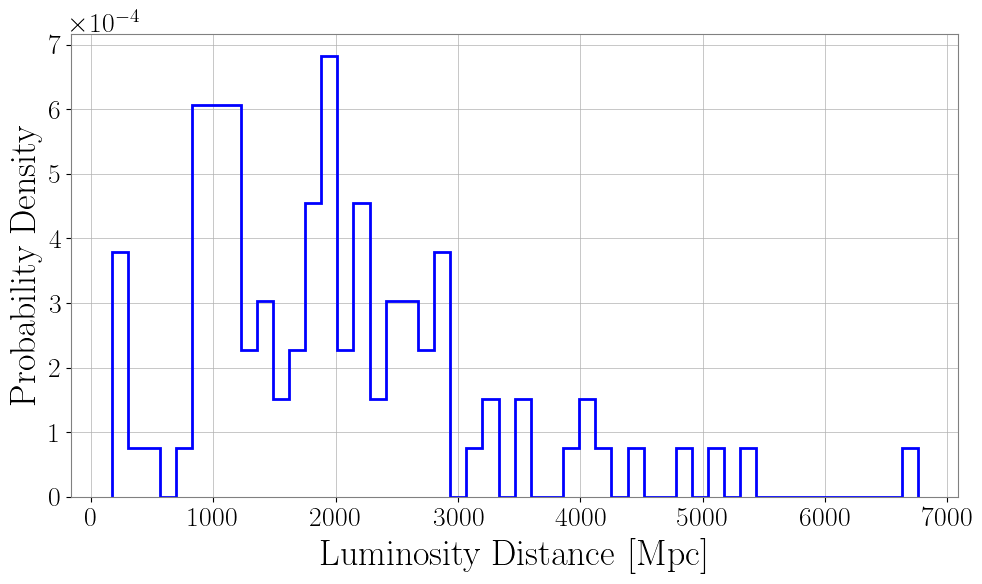

random seed for param sampling: 42


100%|██████████| 100/100 [00:10<00:00,  9.51it/s]


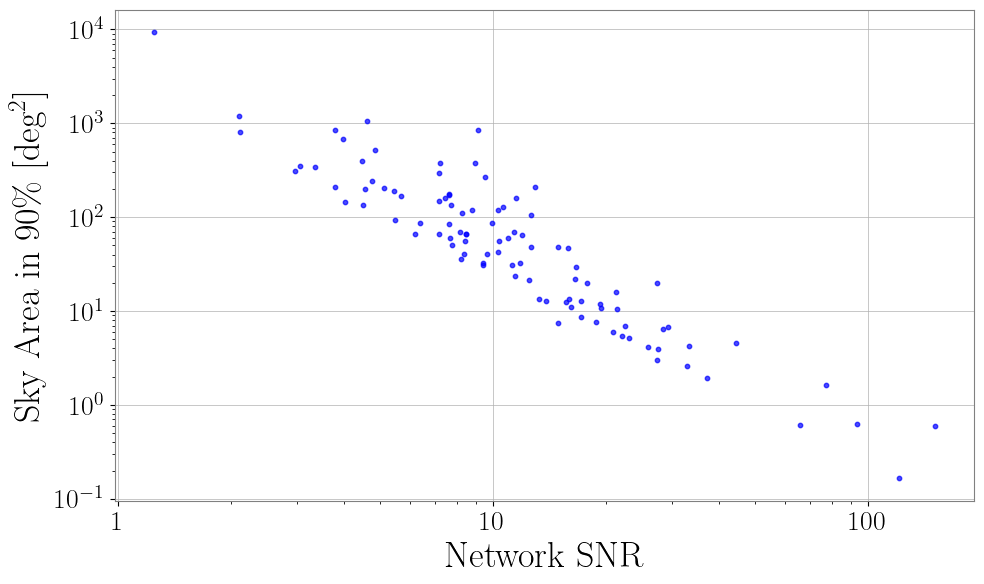

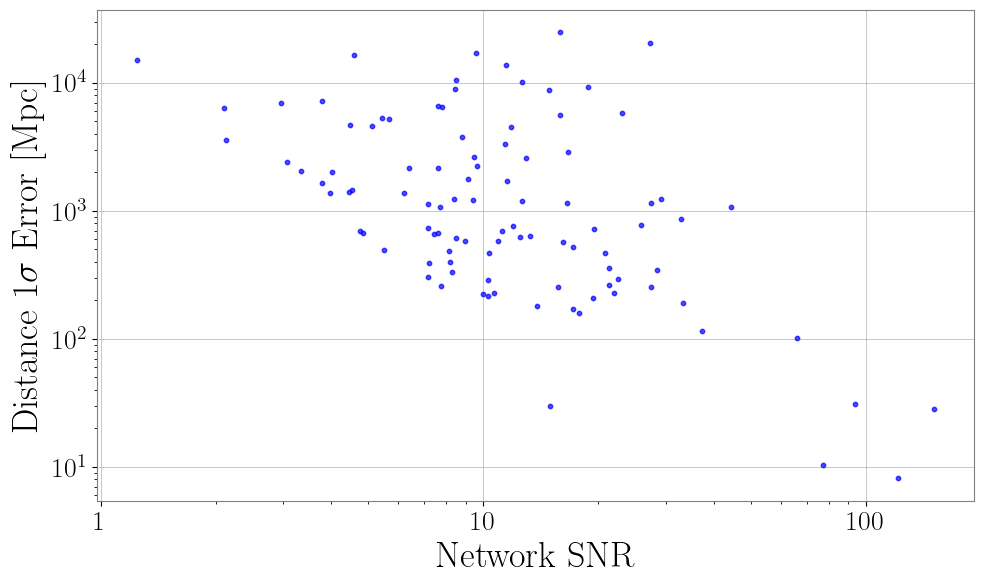

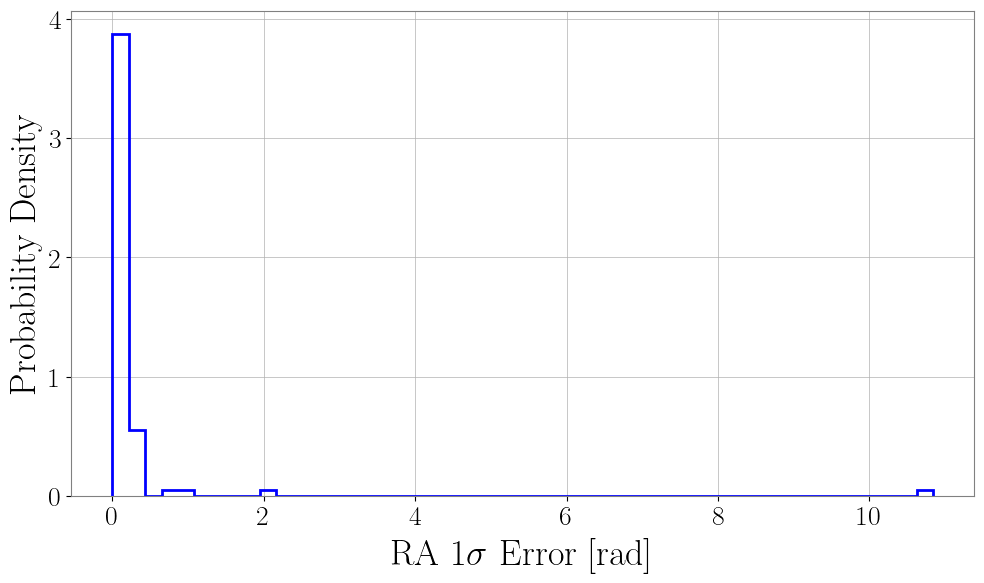

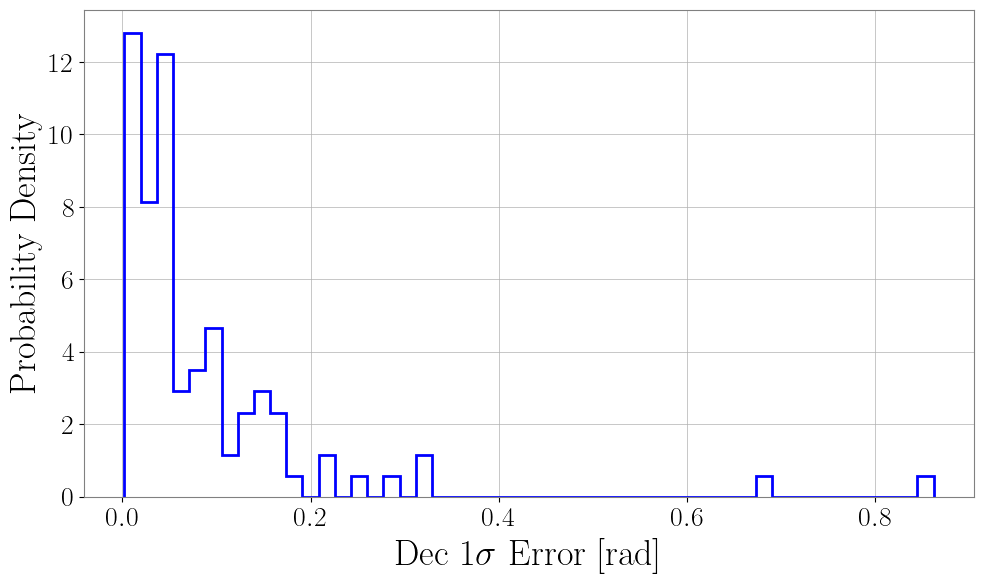

ramdom seed for distance measurement error: 43
Resampling 10 negative distance values...
Resampling 5 negative distance values...
Resampling 2 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Resampling 1 negative distance values...
Number of detected events (SNR >= 8.0): 67 out of 100 samples.


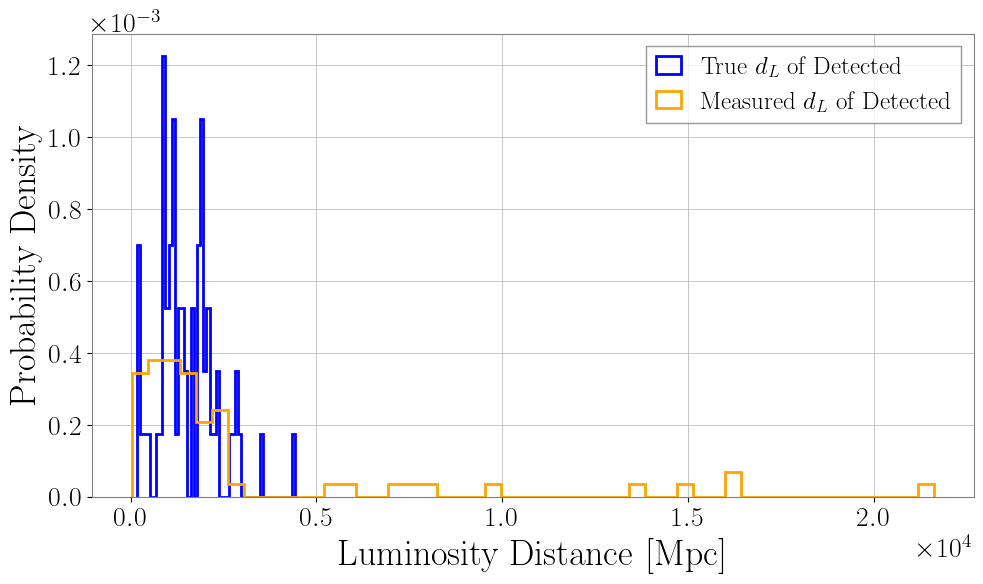

Sky area (90% C.I.) closest to 10.0 deg^2: 0.39603463459483024 deg^2
Injection parameters of the event chosen here:
  mass_1: 30.0
  mass_2: 30.0
  chi_1: 0.0
  chi_2: 0.0
  luminosity_distance: 973.5358462781894
  geocent_time: 1187008882.4
  ra: 62.3914980559008
  dec: -36.66813520042837
  theta_jn: 1.900574358971273
  psi: 3.117639781639845
  phase: 3.1700318395446816


In [7]:
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import norm
from scipy.interpolate import interp1d
import bilby
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors
import GWFish.modules.waveforms as wf
from run_fisher_analysis import fisher_analysis_GWfish

"""cosmological parameters used in the simulation"""
h = 0.71
omega_cdm = 0.1109
omega_b = 0.02258
n_s = 0.963
sigma_8 = 0.8
w = -1.0

omega_m = (omega_cdm + omega_b) / (h ** 2)
omega_lambda = 1.0 - omega_m
true_H0 = h * 100.0  # in unit of km/s/Mpc
print("Cosmological parameters used in the simulation:")
print(f"H0: {true_H0} km/s/Mpc")
print(f"Omega_m: {omega_m}")
print(f"Omega_lambda: {omega_lambda}")

"""functions for cosmology calculations"""
def luminosity_distance(z, H0, Om=omega_m, Olamda=omega_lambda):
    H0 = H0
    Om = Om
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om)
    return cosmo.luminosity_distance(z).value

def compute_network_SNR_and_sky_area(dL, ra, dec):
    random_seed = 42
    bilby.core.utils.random.seed(random_seed)
    print(f"random seed for param sampling: {random_seed}")
    theta_jn_sample = bilby.core.prior.Sine(name='theta_jn', boundary='reflective').sample(len(dL))
    psi_sample = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi).sample(len(dL))
    phase_sample = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi).sample(len(dL))
    geocent_time = 1187008882.4  # time of GW170817
    
    param_dict = {
            'mass_1': 30.0 * np.ones_like(dL), # in source frame
            'mass_2': 30.0 * np.ones_like(dL), # in source frame
            'chi_1': 0.0 * np.ones_like(dL), 'chi_2': 0.0 * np.ones_like(dL),
            'luminosity_distance': dL,
            'geocent_time': geocent_time * np.ones_like(dL),
            'ra': ra,
            'dec': dec,
            'theta_jn': theta_jn_sample,
            'psi': psi_sample,
            'phase': phase_sample,
        }
    
    ### GWFish source code is modified by myself, but simpler calculation is working with the original code. ###
    ### For running the original code, see the documentation: https://gwfish.readthedocs.io/en/latest/tutorials/tutorial_170817.html ###
    params_df, network_snr, sky_area_deg2_90_list, ra_1sigma_error_list, dec_1sigma_error_list, corr_ra_dec_list, dL_1sigma_error_list = fisher_analysis_GWfish(param_dict)
    return params_df, network_snr, sky_area_deg2_90_list, ra_1sigma_error_list, dec_1sigma_error_list, corr_ra_dec_list, dL_1sigma_error_list

"""filter galaxy catalog by apparent magnitude"""
galcat_df = gal_small_fiducial_df.copy()

mag_cut_r = 21
mask = galcat_df['mag_true_r_lsst_no_host_extinction'] <= mag_cut_r
filtered_df = galcat_df.loc[mask]
true_redshifts_masked = galcat_df.loc[mask, 'redshift_true']
true_redshifts_range = [np.min(true_redshifts_masked), np.max(true_redshifts_masked)]
ra_masked = galcat_df.loc[mask, 'ra_true']
dec_masked = galcat_df.loc[mask, 'dec_true']

"""sample galaxies from the catalog according to weights"""
sample_size = 100
weights = np.ones_like(true_redshifts_masked) / len(true_redshifts_masked) # uniform weighting
# weights = 3.828e26 * 10**(-0.4 * galcat_df.loc[mask, 'Mag_true_r_lsst_z0_no_host_extinction']) / np.sum(3.828e26 * 10**(-0.4 * galcat_df.loc[mask, 'mag_true_r_lsst_no_host_extinction'])) # weighting by luminosity
gal_random_seed = 41
np.random.seed(gal_random_seed)
print(f'random seed for galaxy sampling: {gal_random_seed}')
sample_indices = np.random.choice(filtered_df.index, size=sample_size, replace=False, p=weights)
sample_ra = np.array(filtered_df.loc[sample_indices, 'ra_true'])
sample_dec = np.array(filtered_df.loc[sample_indices, 'dec_true'])
sampled_true_z = np.array(filtered_df.loc[sample_indices, 'redshift_true'])
sample_true_dL = luminosity_distance(sampled_true_z, true_H0)

plt.style.use('~/research/my_plot_style.style')
plt.figure()
plt.hist(sample_true_dL, bins=50, density=True, color='blue', histtype='step', lw=2)
plt.xlabel('Luminosity Distance [Mpc]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

"""compute network SNRs and sky localization areas"""
params_df, network_snr, sky_area_deg2_90_list, ra_1sigma_error_list, dec_1sigma_error_list, corr_ra_dec_list, dL_1sigma_error_list = compute_network_SNR_and_sky_area(sample_true_dL, sample_ra, sample_dec)

plt.figure()
plt.scatter(network_snr, sky_area_deg2_90_list, s=10, color='blue', alpha=0.7)
plt.xlabel('Network SNR')
plt.ylabel(r'Sky Area in $90\%$ [deg$^2$]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(network_snr, dL_1sigma_error_list, s=10, color='blue', alpha=0.7)
plt.xlabel('Network SNR')
plt.ylabel(r'Distance $1\sigma$ Error [Mpc]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(ra_1sigma_error_list, bins=50, density=True, color='blue', histtype='step', lw=2)
plt.xlabel(r'RA $1\sigma$ Error [rad]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(dec_1sigma_error_list, bins=50, density=True, color='blue', histtype='step', lw=2)
plt.xlabel(r'Dec $1\sigma$ Error [rad]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

dL_random_seed = 43
np.random.seed(dL_random_seed)
print(f'ramdom seed for distance measurement error: {dL_random_seed}')
measured_dL = np.random.normal(loc=sample_true_dL, scale=dL_1sigma_error_list)
negative_mask = measured_dL <= 0
while np.any(negative_mask):
    print(f"Resampling {np.sum(negative_mask)} negative distance values...")
    measured_dL[negative_mask] = np.random.normal(loc=sample_true_dL[negative_mask], scale=dL_1sigma_error_list[negative_mask])
    negative_mask = measured_dL <= 0

"""impose detection threshold"""
snr_threshold = 8.0
detected_mask = network_snr >= snr_threshold
detected_snr = network_snr[detected_mask]
print(f"Number of detected events (SNR >= {snr_threshold}): {len(detected_snr)} out of {sample_size} samples.")
detected_dL = measured_dL[detected_mask]
detected_true_z = sampled_true_z[detected_mask]

plt.figure()
plt.hist(sample_true_dL[detected_mask], bins=50, density=True, color='blue', histtype='step', lw=2, label=r'True $d_L$ of Detected')
plt.hist(detected_dL, bins=50, density=True, color='orange', histtype='step', lw=2, label=r'Measured $d_L$ of Detected')
plt.xlabel('Luminosity Distance [Mpc]')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

"""pick up good events"""
# best_snr = np.max(network_snr)
# print(f"Largest detected SNR: {best_snr}")
# best_index = np.argmax(network_snr)

# best_localization = np.min(sky_area_deg2_90_list)
# best_index = np.argmin(sky_area_deg2_90_list)
# print(f"Smallest sky area (90% C.I.): {best_localization} deg^2")

fiducial_localization = 10.0  # deg^2
best_localization = np.min(np.abs(sky_area_deg2_90_list-fiducial_localization))  # pick up closest to 10 deg^2
best_index = np.argmin(np.abs(sky_area_deg2_90_list-fiducial_localization))
print(f"Sky area (90% C.I.) closest to {fiducial_localization} deg^2: {best_localization} deg^2")

best_injection = params_df.iloc[best_index]
print("Injection parameters of the event chosen here:")
for key, value in best_injection.items():
    print(f"  {key}: {value}")


# Generate mock skymap

In [4]:
import numpy as np
import healpy as hp
from astropy.io import fits
from scipy.stats import multivariate_normal
from tqdm import tqdm


def create_fits_skymap_assuming_gaussian(ra_val, dec_val, ra_err, dec_err, corr, dL_val, dL_err, filename="../data/skymap.fits", nside=1024, be_nested=False):
    npix = hp.nside2npix(nside)
    
    theta, phi = hp.pix2ang(nside, np.arange(npix))
    ra_pix = phi
    dec_pix = 0.5 * np.pi - theta

    d_ra = (ra_pix - ra_val)
    d_ra = (d_ra + np.pi) % (2 * np.pi) - np.pi # -pi ~ pi に収める

    d_ra_scaled = d_ra * np.cos(dec_val)
    d_dec = dec_pix - dec_val

    sigma_x = ra_err * np.cos(dec_val) # RA方向の実距離成分
    sigma_y = dec_err
    cov = np.array([
        [sigma_x**2, corr * sigma_x * sigma_y],
        [corr * sigma_x * sigma_y, sigma_y**2]
    ])
    
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    a = inv_cov[0, 0]
    b = inv_cov[0, 1]
    d = inv_cov[1, 1]
    
    exponent = -0.5 * (a * d_ra_scaled**2 + 2 * b * d_ra_scaled * d_dec + d * d_dec**2)
    prob = np.exp(exponent)
    
    prob_sum = np.sum(prob)
    if prob_sum > 0:
        prob /= prob_sum
    else:
        dist_ang = d_ra_scaled**2 + d_dec**2
        prob[np.argmin(dist_ang)] = 1.0

    distmu = np.ones(npix) * dL_val
    distsigma = np.ones(npix) * dL_err
    distnorm = np.ones(npix) / (distmu**2 + distsigma**2)

    col_prob = fits.Column(name='PROB', format='D', unit='pix-1', array=prob)
    col_distmu = fits.Column(name='DISTMU', format='D', unit='Mpc', array=distmu)
    col_distsigma = fits.Column(name='DISTSIGMA', format='D', unit='Mpc', array=distsigma)
    col_distnorm = fits.Column(name='DISTNORM', format='D', unit='Mpc-2', array=distnorm)

    cols = fits.ColDefs([col_prob, col_distmu, col_distsigma, col_distnorm])
    hdu = fits.BinTableHDU.from_columns(cols)

    hdu.header['PIXTYPE'] = 'HEALPIX'
    hdu.header['COORDSYS'] = 'C' # Celestial (Equatorial)
    hdu.header['NSIDE'] = nside
    hdu.header['INDXSCHM'] = 'IMPLICIT'
    hdu.header['OBJECT'] = 'MOCK_EVENT'
    
    if be_nested:
        # transform from RING to NESTED
        prob_nested = hp.reorder(prob, r2n=True)
        distmu_nested = hp.reorder(distmu, r2n=True)
        distsigma_nested = hp.reorder(distsigma, r2n=True)
        distnorm_nested = hp.reorder(distnorm, r2n=True)

        col_prob = fits.Column(name='PROB', format='D', unit='pix-1', array=prob_nested)
        col_distmu = fits.Column(name='DISTMU', format='D', unit='Mpc', array=distmu_nested)
        col_distsigma = fits.Column(name='DISTSIGMA', format='D', unit='Mpc', array=distsigma_nested)
        col_distnorm = fits.Column(name='DISTNORM', format='D', unit='Mpc-2', array=distnorm_nested)

        cols = fits.ColDefs([col_prob, col_distmu, col_distsigma, col_distnorm])
        hdu = fits.BinTableHDU.from_columns(cols)

        hdu.header['PIXTYPE'] = 'HEALPIX'
        hdu.header['ORDERING'] = 'NESTED'
        hdu.header['COORDSYS'] = 'C'
        hdu.header['NSIDE'] = nside
        hdu.header['INDXSCHM'] = 'IMPLICIT'
        hdu.header['OBJECT'] = 'MOCK_EVENT'

        print(f"Generated FITS file: {filename} (NESTED)")        
    else:
        hdu.header['ORDERING'] = 'RING'
        print(f"Generated FITS file: {filename} (RING)")

    primary_hdu = fits.PrimaryHDU()
    hdul = fits.HDUList([primary_hdu, hdu])
    hdul.writeto(filename, overwrite=True)
    

target_ra = best_injection['ra']
target_dec = best_injection['dec']
target_ra_rad = np.deg2rad(target_ra)
target_dec_rad = np.deg2rad(target_dec)
target_ra_err = ra_1sigma_error_list[best_index]
target_dec_err = dec_1sigma_error_list[best_index]
target_corr = corr_ra_dec_list[best_index]
target_dist = measured_dL[best_index]
target_dist_err = dL_1sigma_error_list[best_index]

GW_sky_map_file_path = "./data/gw_sim_skymap.fits"
create_fits_skymap_assuming_gaussian(
    ra_val=target_ra_rad,
    dec_val=target_dec_rad,
    ra_err=target_ra_err,
    dec_err=target_dec_err,
    corr=target_corr,
    dL_val=target_dist,
    dL_err=target_dist_err,
    filename=GW_sky_map_file_path,
    nside=1024,
    be_nested=False
)

Generated FITS file: ./data/gw_sim_skymap.fits (RING)


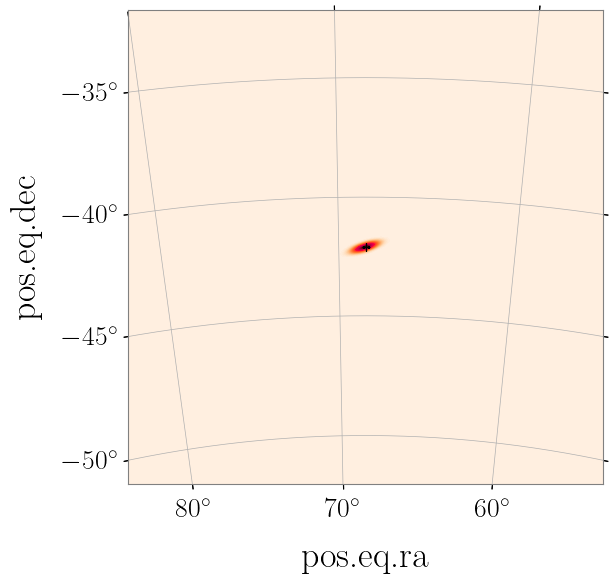

sum of PROB: 0.9999999999999998


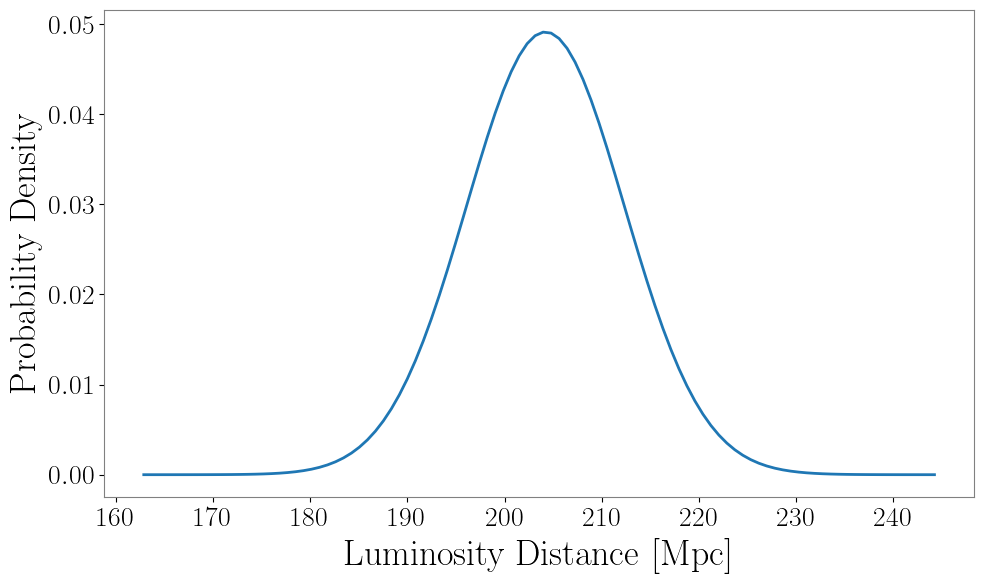

sum of p_dL: 0.999999389967354


In [5]:
from astropy.coordinates import EarthLocation
from astropy.time import Time
from ligo.skymap.coordinates import DetectorFrame
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from matplotlib import pyplot as plt
from ligo.skymap.postprocess import contour
import astropy.units as u
from astropy.coordinates import SkyCoord

"""import fits skymap"""
(prob, distmu, distsigma, distnorm), meta = read_sky_map(GW_sky_map_file_path, distances=True, moc=False)

npix = len(prob)
nside = hp.npix2nside(npix)
max_idx = np.argmax(prob)
theta, phi = hp.pix2ang(nside, max_idx)
ra_deg = np.rad2deg(phi)
dec_deg = np.rad2deg(0.5 * np.pi - theta)
plt.figure()
center_coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit='deg')
ax = plt.axes(projection='astro zoom', center=center_coord, radius=10 * u.deg) 
ax.imshow_hpx(prob, cmap='cylon')
ax.plot(ra_deg, dec_deg, transform=ax.get_transform('world'), marker='+', color='k')
ax.coords[0].set_format_unit(u.deg)
ax.coords[1].set_format_unit(u.deg)
ax.grid(True)
plt.show()
print(f'sum of PROB: {np.sum(prob)}')

dL_array = np.linspace(distmu[0]-5*distsigma[0], distmu[0]+5*distsigma[0], 100)
p_dL = []
plt.figure()
for rr in dL_array:
    p_dL.append(np.sum(prob * rr**2 * distnorm * norm(distmu, distsigma).pdf(rr)))
plt.plot(dL_array, p_dL)
plt.xlabel('Luminosity Distance [Mpc]')
plt.ylabel('Probability Density')
# plt.legend()
plt.grid()
plt.show()
print(f'sum of p_dL: {np.trapz(p_dL, dL_array)}')

# Compute likelihood

Number of galaxies after applying distance and sky position cuts: 5 out of 211882


100%|██████████| 100/100 [00:00<00:00, 454.86it/s]
/var/folders/91/6k_wr_bj7r9cg9669rd966jc0000gn/T/ipykernel_18394/1125661844.py:149: RuntimeWarning: invalid value encountered in divide
  post /= np.sum(post)


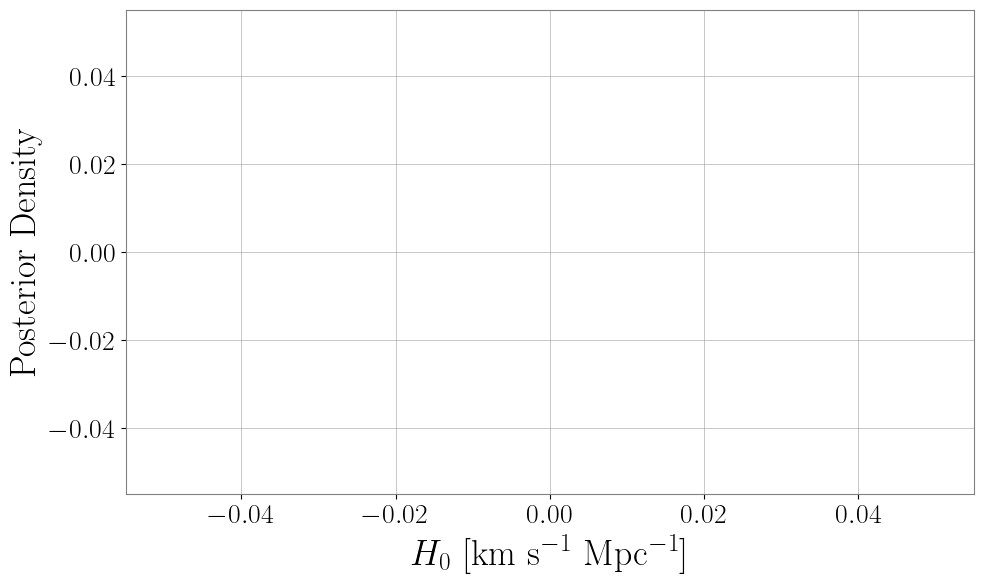

In [ ]:
import healpy as hp
import numpy as np
import h5py, os
from scipy.interpolate import CubicSpline
from scipy.integrate import trapezoid
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from astropy.cosmology import FlatLambdaCDM, z_at_value, Planck18
import pandas as pd
import astropy.constants as const

from ligo.skymap.postprocess import crossmatch
from ligo.skymap.io import read_sky_map

###constants###
Mo = const.M_sun.value #solar mass [kg]
G = const.G.value #Newton constant [m^3 kg^-1 s^2]
c = const.c.value #light speed [m s^-1]
pc = const.pc.value #1pc [m]
###############

def z_from_dL(dL, H0, Om=omega_m):
    H0 = H0
    Om0 = Om
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
    if np.isscalar(dL):
         z = z_at_value(cosmo.luminosity_distance, dL * u.Mpc, zmin=0.0)
    else:
         z = np.array([z_at_value(cosmo.luminosity_distance, d_i * u.Mpc, zmin=0.0) for d_i in dL])
    return z

def E(z, _O_m=omega_m):
    cosmo = FlatLambdaCDM(H0=70, Om0=_O_m)
    return 1 / cosmo.efunc(z)

def comoving_distance(z_array, H0, n_points=10, O_m=omega_m):
    cosmo = FlatLambdaCDM(H0=H0, Om0=O_m)
    return cosmo.comoving_distance(z_array).value

def luminosity_distance(z, H0, n_points=10, O_m=omega_m):
    cosmo = FlatLambdaCDM(H0=H0, Om0=O_m)
    return cosmo.luminosity_distance(z).value

def create_cosmo_interpolator(H0):
    dl_table = luminosity_distance(z_table, H0, 1000)
    return CubicSpline(z_table, dl_table)

def gauss(x, m, s, n=1):
    return n*(s*np.sqrt(2*np.pi))**(-1)*np.exp(-0.5*((x-m)/s)**2)

def madau(z, gamma=4.59, k=2.86, zp=2.47):
    return (1+((1+zp)**(-gamma-k)))*((1+z)**(gamma-1))/(1+(((1+z)/(1+zp))**(gamma+k)))

def likelihood(z_array, H0, dl_interp, gal_z, gal_zsigma, gal_m, gal_p, gal_distmu, gal_distsig, gal_distnorm):
    
    dl_array = dl_interp(z_array)
    
    # p_rate = madau(z_array)
    p_rate = np.ones(len(z_array)) # Uniform in comoving volume and source-frame time
    
    integrand_array = (dl_array/(1+z_array))**2 * c*1e-3 / (H0*E(z_array))
    
    gal_absmag = gal_m - 5*np.log10(dl_interp(gal_z)*1e6)+5 # For high z, k corrections are needed here
    # gal_lum = 3.828e26*10**(-0.4*(gal_absmag)) # Luminosity weighting
    gal_lum = np.ones(len(gal_absmag)) # Uniform weighting
    # lum_mask = gal_absmag<M_max+5*np.log10(H0/100)
    
    likelihood = 0
    for i in np.arange(len(gal_z)):
        p_em = gal_lum[i]*gauss(z_array, gal_z[i], gal_zsigma[i])*p_rate
        p_gw = gauss(dl_array, gal_distmu[i], gal_distsig[i], gal_distnorm[i]*gal_p[i])
        evidence = trapezoid(p_em*integrand_array, z_array)
        if evidence==0:
            continue
        likelihood += trapezoid(p_em*p_gw*integrand_array, z_array)/evidence
    beta = H0**(3)
    return likelihood/beta

h0_array_params = (20, 140, 100) # H0 grid for likelihood eval
h0_array = np.linspace(*h0_array_params)
z_array = np.linspace(0.001, 1, 4990)

"""GW data"""
p, distnorm, distmu, distsig = hp.read_map(GW_sky_map_file_path, field=[0, 1, 2, 3]) # should be RING, not NEST
nside = hp.npix2nside(len(p))

"""Create array of splines for luminosity distance"""
interp_file = './data/h0_interpolators_{}_{}_{}.pickle'.format(*h0_array_params)
if os.path.exists(interp_file):
    with open(interp_file, 'rb') as f:
        h0_interpolators = pickle.load(f)
else:
    h0_interpolators = []
    for i in tqdm(range(len(h0_array))):
        h0_interpolators.append(create_cosmo_interpolator(h0_array[i]))
    with open(interp_file, 'wb') as f:
        pickle.dump(h0_interpolators, f)

"""load galaxy catalog filtered by apparent magnitude in r band"""
galaxy_df = filtered_df.copy()
gal_ra = np.array(galaxy_df['ra_true'][:])
gal_dec = np.array(galaxy_df['dec_true'][:])
gal_mr = np.array(galaxy_df['mag_true_r_lsst_no_host_extinction'][:])
gal_true_z = np.array(galaxy_df['redshift_true'][:])
gal_measured_z = np.array(galaxy_df['redshift_measured'][:])
gal_z_sigma = np.abs(gal_true_z - gal_measured_z)

while np.any(gal_measured_z <= 0):
    mask = gal_measured_z <= 0
    gal_measured_z[mask] = np.random.normal(gal_true_z[mask], gal_z_sigma[mask])
    
"""make galaxy selections"""
### distance ###
percentile_80_for_gaussian = 1.28155
# percentale_90_for_gaussian = 1.64485
# percentile_95_for_gaussian = 1.95996
gal_dL_for_largest_H0 = luminosity_distance(gal_measured_z, H0=np.max(h0_array))
distance_mask = (gal_dL_for_largest_H0<distmu[0]+percentile_80_for_gaussian*distsig[0]) # in UPPER 90% credible interval

### sky position ###
sky_map = read_sky_map(GW_sky_map_file_path, moc=True, distances=True)
galaxy_catalog = SkyCoord(ra=gal_ra[distance_mask], dec=gal_dec[distance_mask], distance=gal_dL_for_largest_H0[distance_mask], unit=['deg', 'deg', 'Mpc'])
crossmatch_result = crossmatch(sky_map=sky_map, coordinates=galaxy_catalog, cosmology=False, modes=False)
is_in_90Sky_mask = (crossmatch_result.searched_prob < 0.9)

full_mask = distance_mask.copy()
full_mask[distance_mask] = is_in_90Sky_mask

print(f"Number of galaxies after applying distance and sky position cuts: {np.sum(full_mask)} out of {len(galaxy_df)}")

masked_gal_ra = gal_ra[full_mask]
masked_gal_dec = gal_dec[full_mask]
masked_gal_true_z = gal_true_z[full_mask]
masked_gal_measured_z = gal_measured_z[full_mask]
masked_gal_z_sigma = gal_z_sigma[full_mask]
masked_gal_mr = gal_mr[full_mask]

gal_hpx_idx = hp.ang2pix(nside, masked_gal_ra, masked_gal_dec, lonlat=True, nest=False)
gal_p = p[gal_hpx_idx]
gal_distmu = distmu[gal_hpx_idx]
gal_distsig = distsig[gal_hpx_idx]
gal_distnorm = distnorm[gal_hpx_idx]

"""Evaluate H0 likelihood"""
post = np.zeros(len(h0_array))
for i in tqdm(range(len(h0_array))):
    post[i] = likelihood(z_array, h0_array[i], h0_interpolators[i], masked_gal_measured_z, masked_gal_z_sigma, masked_gal_mr, gal_p, gal_distmu, gal_distsig, gal_distnorm)
post /= np.sum(post)

plt.style.use('~/research/my_plot_style.style')
plt.figure()
plt.plot(h0_array, post, color='blue', lw=2)
plt.xlabel(r'$H_0$ [km s$^{-1}$ Mpc$^{-1}$]')
plt.ylabel('Posterior Density')
plt.grid(True)
plt.show()